<a href="https://colab.research.google.com/github/Meta-user-byte/Percevel/blob/main/Main(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import perceval as pcvl
from perceval.components import PS, BS, Circuit
from IPython.display import SVG
from perceval.rendering.pdisplay import pdisplay

from perceval import BasicState, BackendFactory

from boson_sampler import BosonSampler
import perceval.providers.scaleway as scw

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import numpy as np

from model import MnistModel
# from training import fit

from utils import MNIST_partial, plot_training_metrics

import matplotlib.pyplot as plt

from utils import accuracy
from training import fit

import tqdm

In [ ]:
PQK_features = np.load("/Users/soardr/Perceval 2/Percevel-main/encoded_images_list_final_first3.npy")
PQK_features = torch.from_numpy(PQK_features)

In [ ]:
labels = np.load("/Users/soardr/Perceval 2/Percevel-main/encoded_images_labels_list_final_first3.npy")
labels = torch.from_numpy(labels)

In [ ]:
batch_idx = 0
inner_img_idx = 15

tensor(5)


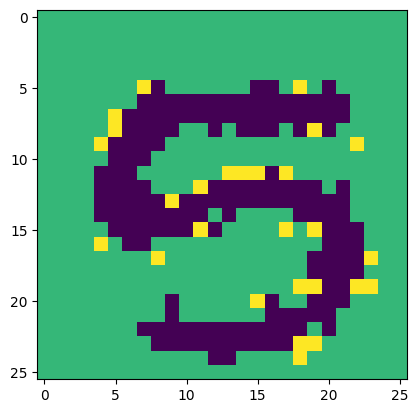

In [ ]:
print(labels[batch_idx][inner_img_idx])
plt.imshow(PQK_features[batch_idx][inner_img_idx][0])

In [ ]:
# hyperparams

epochs = 20
lr = 0.005
path_folder_quantum = "checkpoints PQK quantum batch16"

### Model Definition

In [ ]:
class HybridCNN(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.embedding_size = None

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

        # fc_input_size = 64 * 6 * 6
        fc_input_size = 64 * 6 * 6

        self.fc1 = nn.Linear(fc_input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.drop = nn.Dropout(0.4)

        self.device = device

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.flatten(x2)
        x4 = F.relu(self.fc1(x3))
        x5 = self.drop(F.relu(self.fc2(x4)))
        x6 = self.fc3(x5)

        return x6

    # # def __init__(self, device):
    # #     super().__init__()
    # #     # Increased filter sizes
    # #     self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)  # Input channels = 2
    # #     self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    # #     self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    # #     self.pool = nn.MaxPool2d(2, 2)  # Pooling layer

    # #     # Flatten layer
    # #     self.flatten = nn.Flatten()

    # #     # Fully connected layers
    # #     self.fc1 = nn.Linear(256 * 6 * 6, 256)  # Assuming input size is (2, 48, 48)
    # #     self.fc2 = nn.Linear(256, 128)
    # #     self.fc3 = nn.Linear(128, 10)  # 10 output classes

    # #     # Dropout for regularization
    # #     self.dropout = nn.Dropout(0.3)

    # #     self.embedding_size = None
    # #     self.device = device

    # # def forward(self, x):
    # #     x = self.pool(F.relu(self.conv1(x)))  # Convolution + Pooling
    # #     x = self.pool(F.relu(self.conv2(x)))  # Convolution + Pooling
    # #     x = F.relu(self.conv3(x))  # No pooling in the final conv layer
    # #     x = self.flatten(x)  # Flatten for FC layers
    # #     x = self.dropout(F.relu(self.fc1(x)))  # Fully connected + Dropout
    # #     x = self.dropout(F.relu(self.fc2(x)))  # Fully connected + Dropout
    # #     x = self.fc3(x)  # Output layer
    # #     return x

    # def __init__(self, device):
    #     super().__init__()

    #     self.embedding_size = None

    #     self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1)
    #     self.pool = nn.MaxPool2d(2, 2)
    #     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    #     self.flatten = nn.Flatten()
    #     self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)

    #     fc_input_size = 64 * 6 * 6
    #     # fc_input_size = 32 * 26 * 26

    #     self.fc1 = nn.Linear(fc_input_size, 128)
    #     self.fc2 = nn.Linear(128, 64)
    #     self.fc3 = nn.Linear(64, 32)
    #     self.fc4 = nn.Linear(32, 10)

    #     self.device = device

    #     self.drop = nn.Dropout(0.4)

    # def forward(self, x):
    #     x1 = self.pool(F.relu(self.conv1(x)))
    #     # x1 = F.relu(self.conv3(x1))
    #     x2 = self.pool(F.relu(self.conv2(x1)))
    #     x3 = self.flatten(x2)
    #     x4 = F.relu(self.fc1(x3))
    #     x5 = self.drop(F.relu(self.fc2(x4)))
    #     x6 = F.relu(self.fc3(x5))
    #     x7 = self.drop(F.relu(self.fc4(x6)))

    #     return x7
    #     # x6 = self.fc3(x5)

    #     # return x6

    def training_step(self, batch):
        images, labels =  batch
        images = images.to(self.device)
        labels = labels.to(self.device)

        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        return result['val_loss'], result['val_acc']

### Reshaping the tensors

In [ ]:
PQK_features = PQK_features.reshape(6000, 3, 26, 26)

In [ ]:
labels = labels.reshape(6000)

### Converting from float64 to float32

In [ ]:
PQK_features_converted = []

for idx, item in enumerate(PQK_features):
    item_temp = item * 1e100
    item_temp = (item_temp - item_temp.min()) / (item_temp.max() - item_temp.min())
    item_temp = item_temp.to(dtype=torch.float32)

    PQK_features_converted.append(item_temp)

In [ ]:
PQK_features_converted = torch.stack(PQK_features_converted)

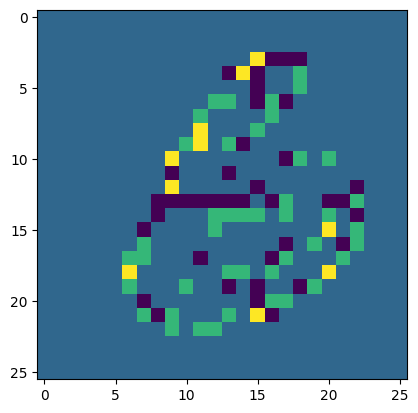

In [ ]:
plt.imshow(PQK_features_converted[0][2])

### Making the new traind and test loader

In [ ]:
from torch.utils.data import random_split, TensorDataset

train_size = int(0.8 * len(PQK_features_converted))  # 80% for training
test_size = len(PQK_features_converted) - train_size
train_data, test_data = random_split(TensorDataset(PQK_features_converted, labels), [train_size, test_size])

# Create DataLoader objects
train_loader_2 = DataLoader(train_data, batch_size=16, shuffle=True)  # Batch size 16
test_loader_2 = DataLoader(test_data, batch_size=16, shuffle=False)

### Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device

device = torch.device(device)

In [ ]:
device

device(type='mps')

### Model

In [ ]:
model_quantum = model_quantum = HybridCNN(device=device)

### Training

inside new version 2
device: mps
model shifted to device: mps
optimizer shifted to device: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


100%|██████████| 300/300 [00:01<00:00, 166.36it/s]


Epoch [0], val_loss: 2.2996, val_acc: 0.1375


100%|██████████| 300/300 [00:01<00:00, 183.39it/s]


Epoch [1], val_loss: 2.2981, val_acc: 0.1375


100%|██████████| 300/300 [00:01<00:00, 177.31it/s]


Epoch [2], val_loss: 2.2979, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 181.11it/s]


Epoch [3], val_loss: 2.2983, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 185.73it/s]


Epoch [4], val_loss: 2.2982, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 188.42it/s]


Epoch [5], val_loss: 2.2972, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 183.27it/s]


Epoch [6], val_loss: 2.2977, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 161.06it/s]


Epoch [7], val_loss: 2.2978, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 170.23it/s]


Epoch [8], val_loss: 2.2979, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 185.51it/s]


Epoch [9], val_loss: 2.2972, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 184.38it/s]


Epoch [10], val_loss: 2.2976, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 186.17it/s]


Epoch [11], val_loss: 2.2976, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 188.12it/s]


Epoch [12], val_loss: 2.2976, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 170.91it/s]


Epoch [13], val_loss: 2.2979, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 181.49it/s]


Epoch [14], val_loss: 2.2975, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 181.51it/s]


Epoch [15], val_loss: 2.2973, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 175.73it/s]


Epoch [16], val_loss: 2.2978, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 175.62it/s]


Epoch [17], val_loss: 2.2985, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 176.42it/s]


Epoch [18], val_loss: 2.2983, val_acc: 0.1367


100%|██████████| 300/300 [00:01<00:00, 185.04it/s]


Epoch [19], val_loss: 2.2981, val_acc: 0.1367


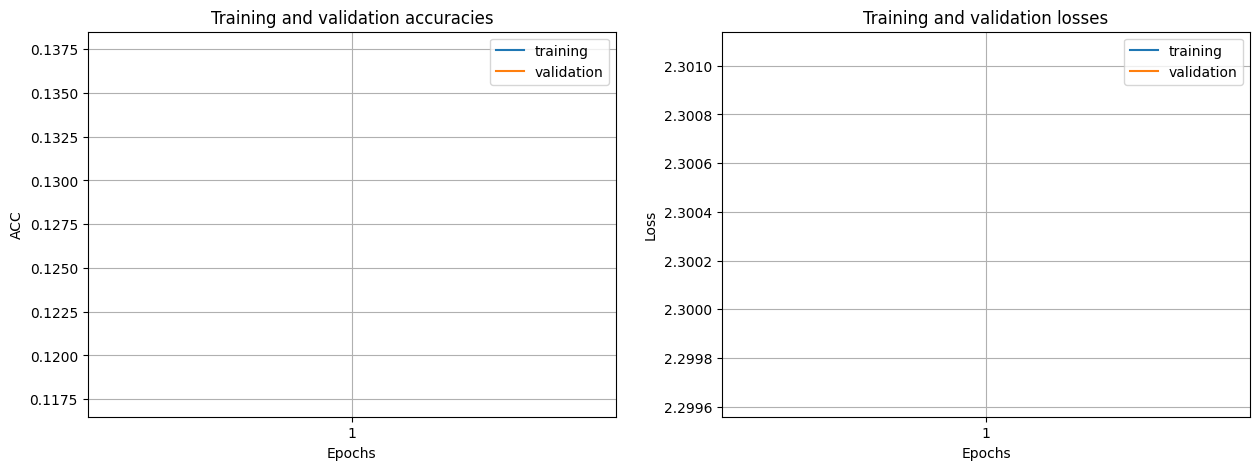

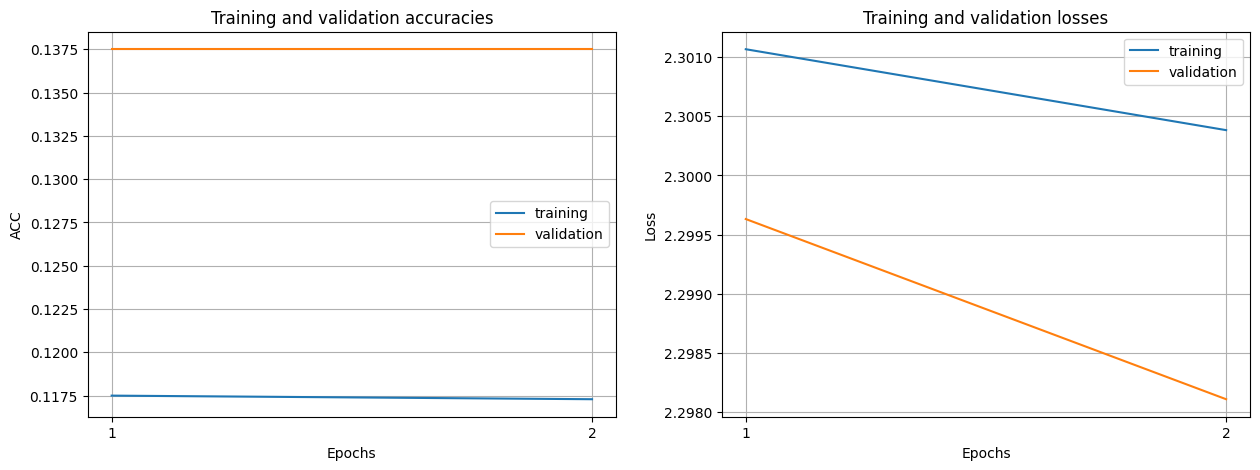

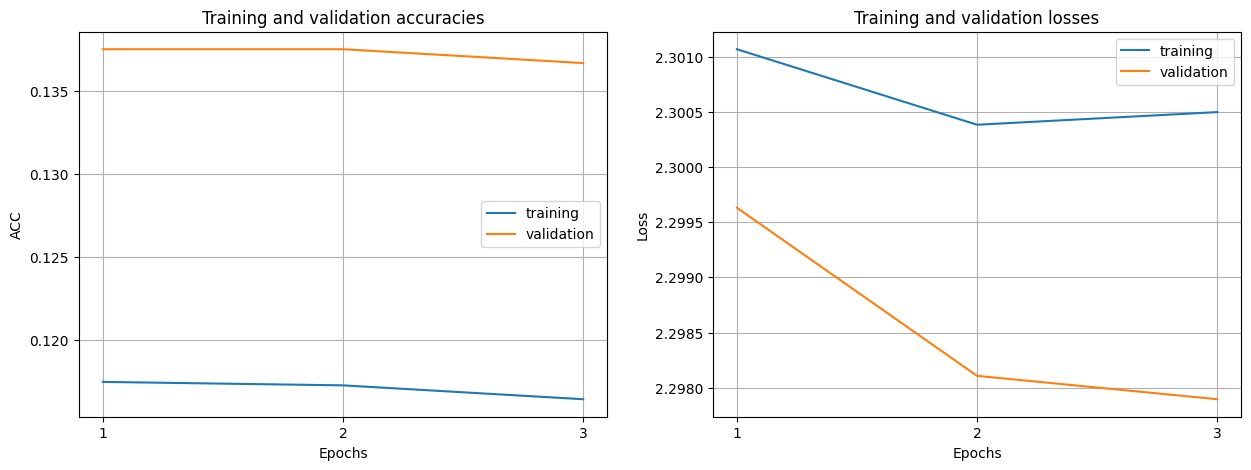

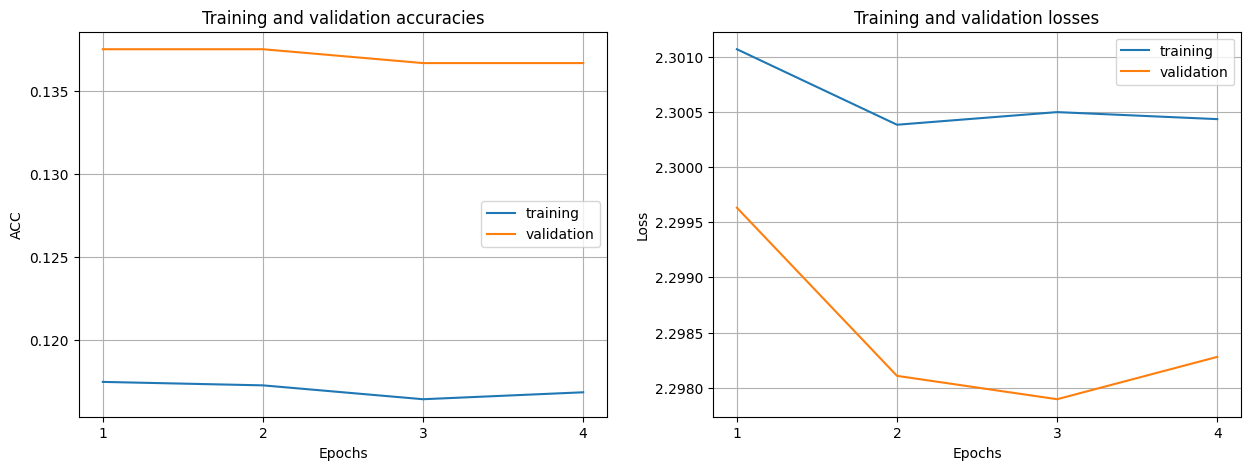

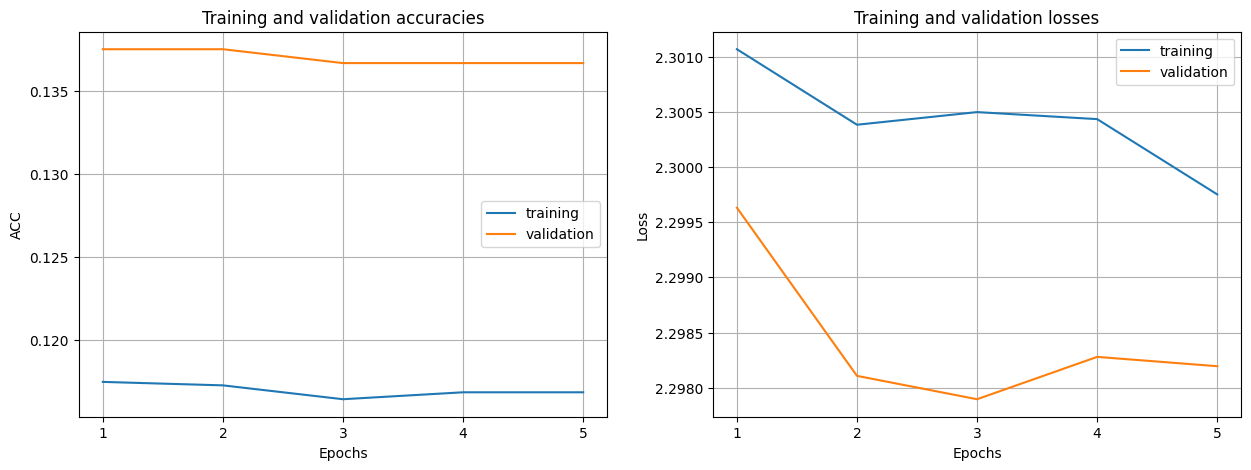

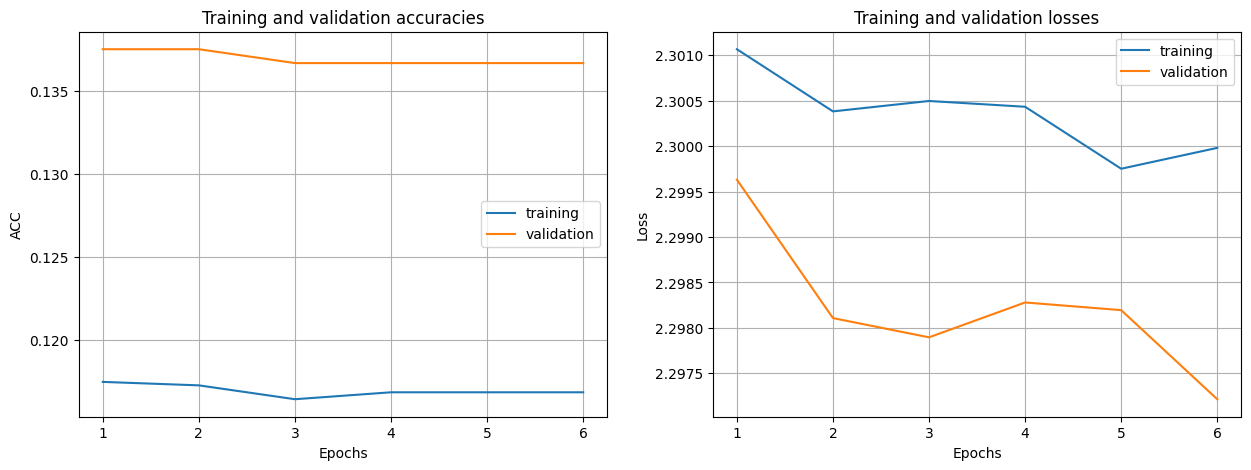

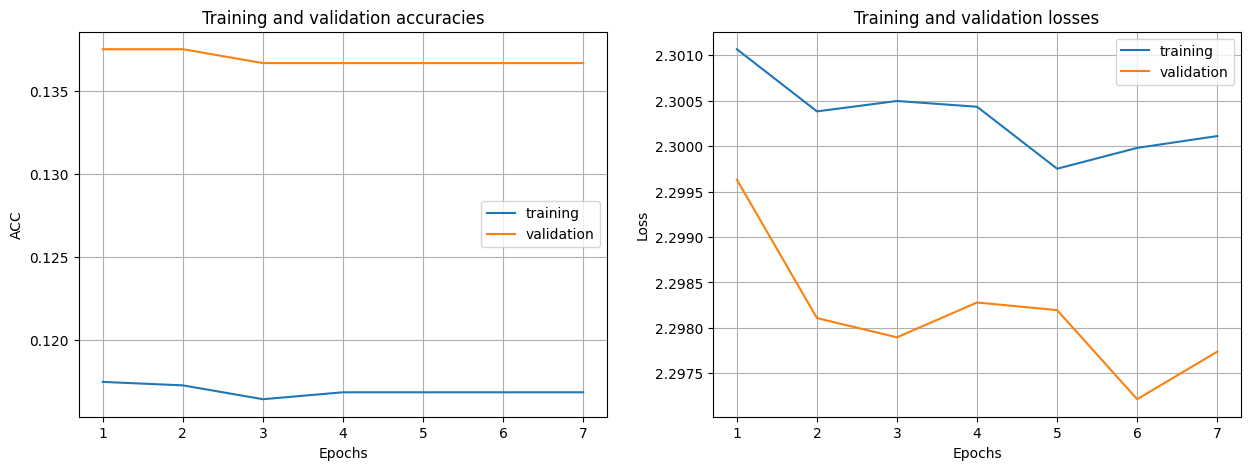

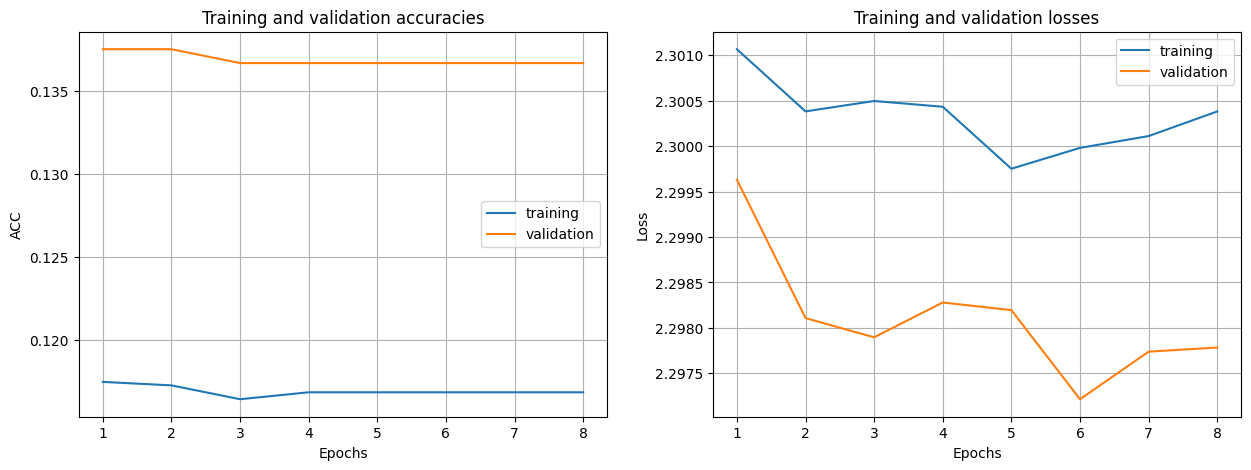

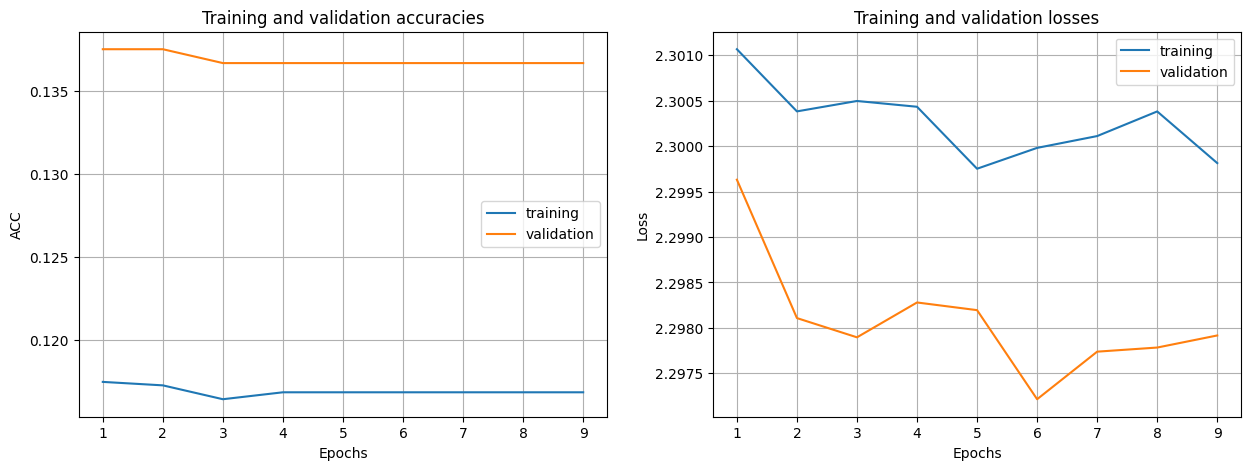

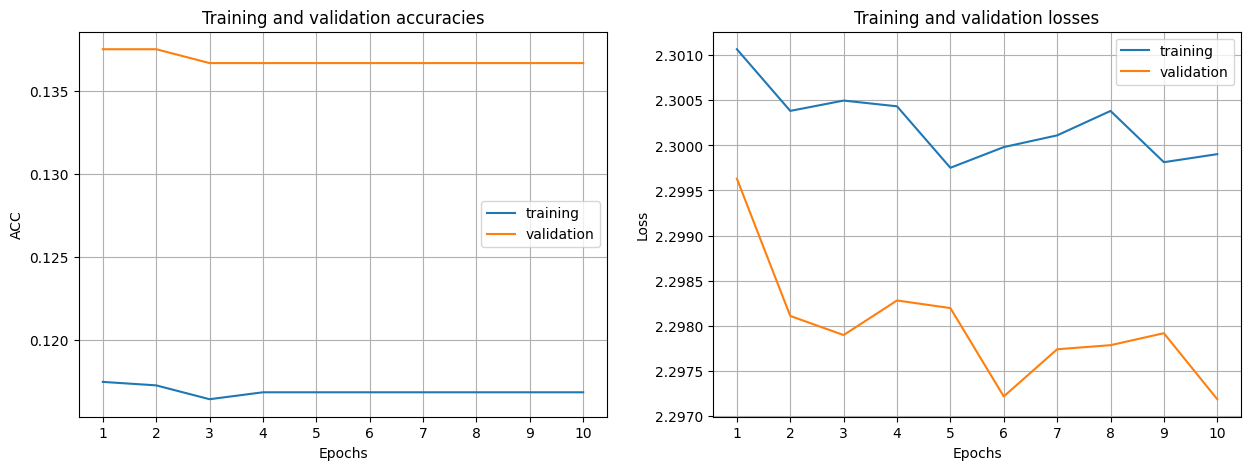

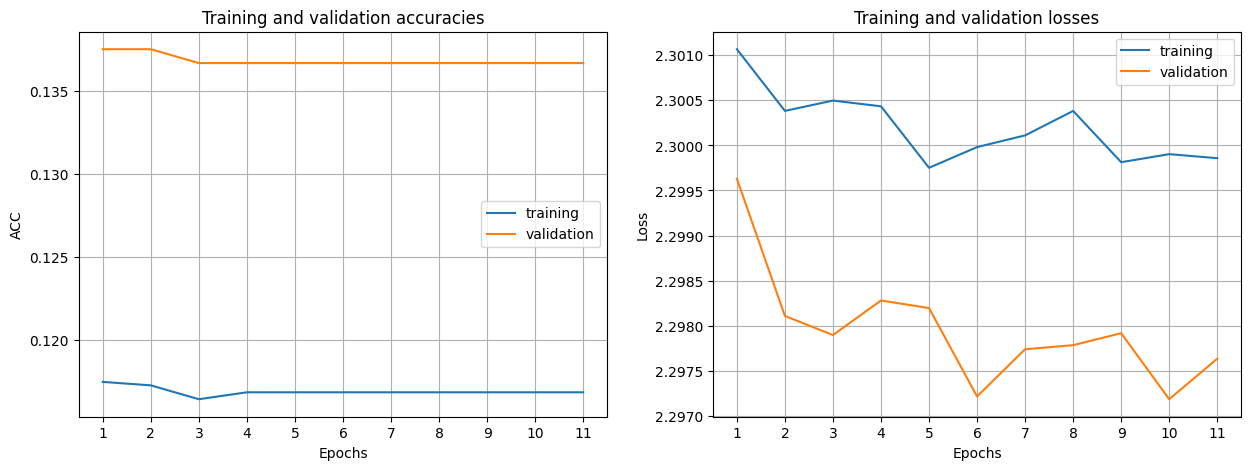

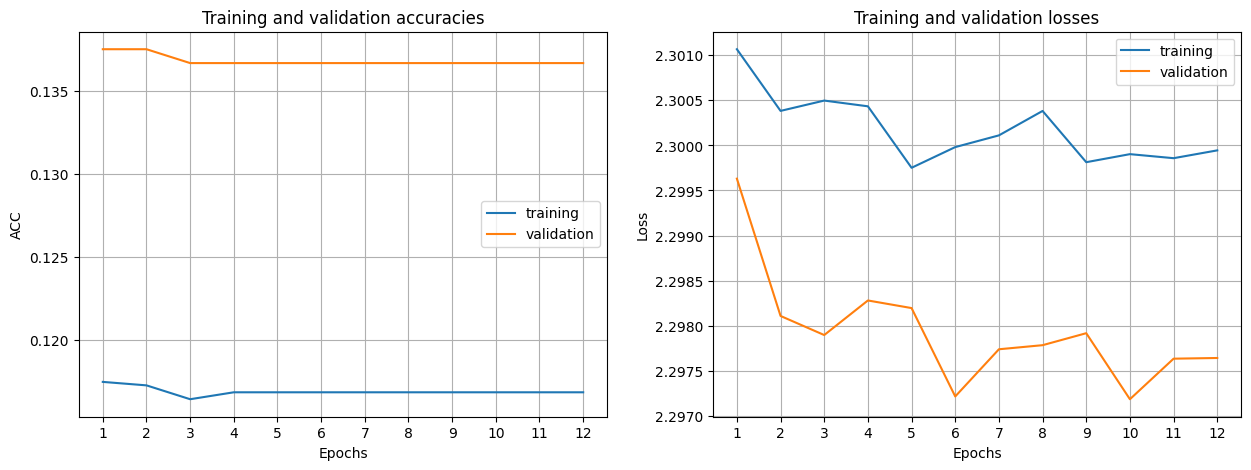

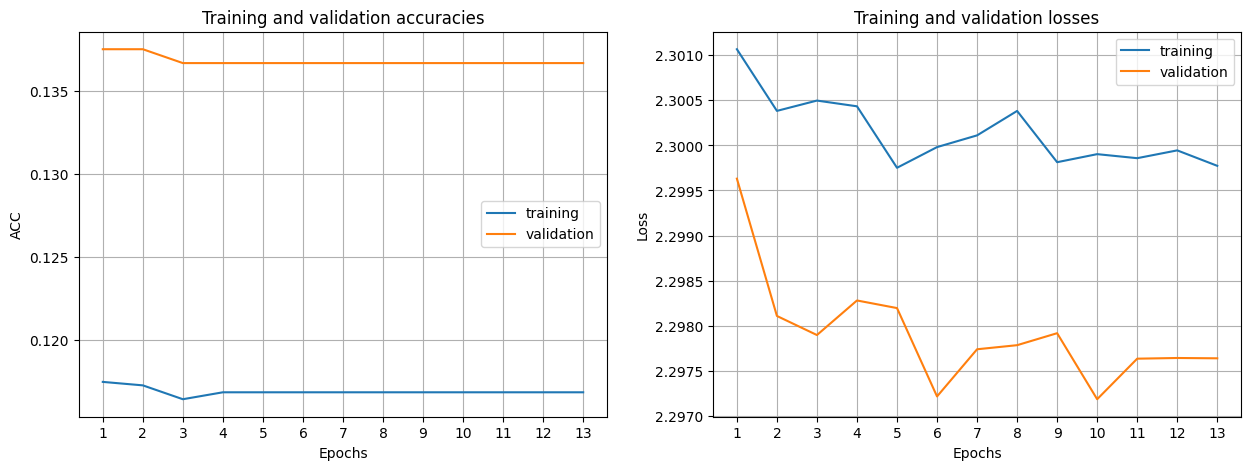

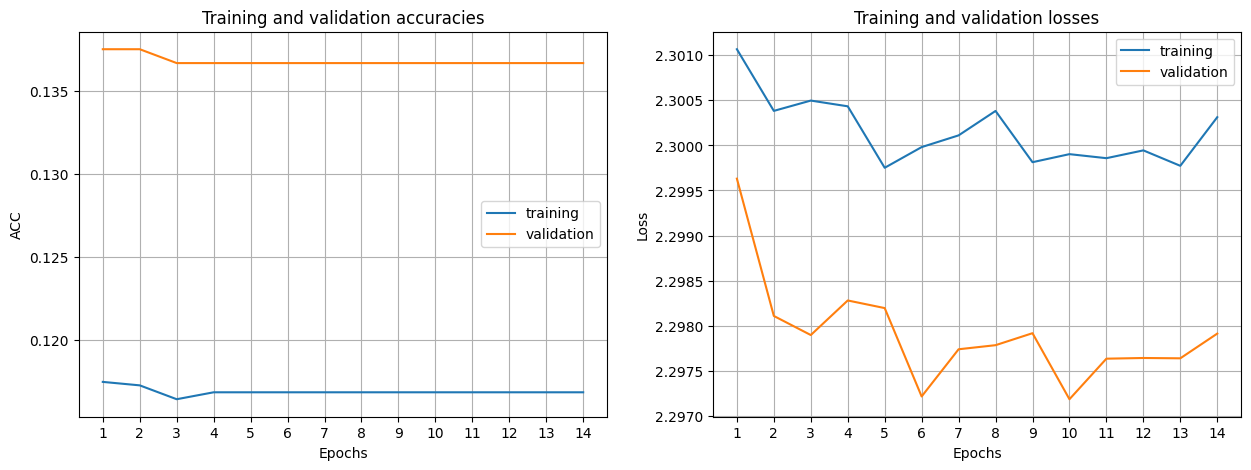

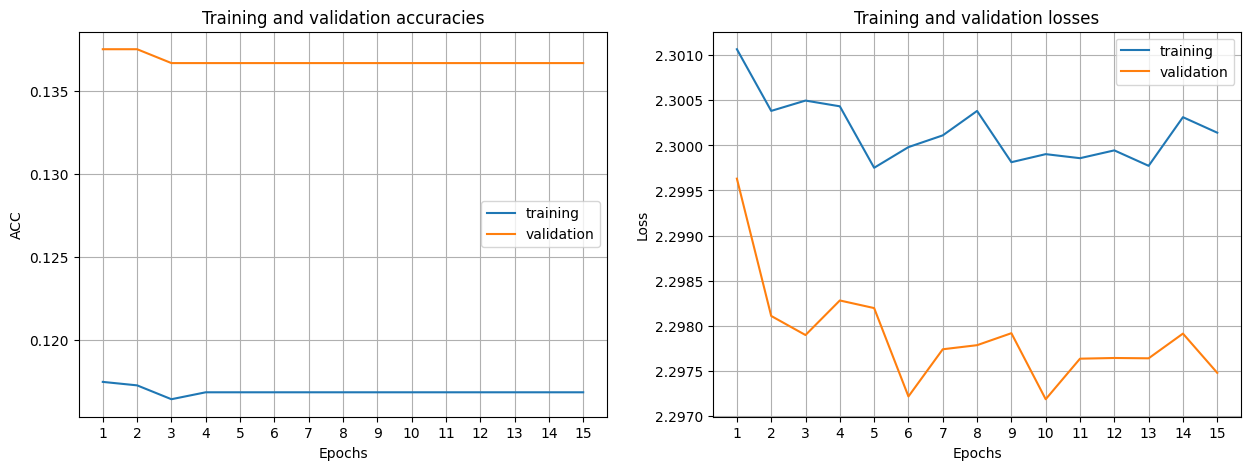

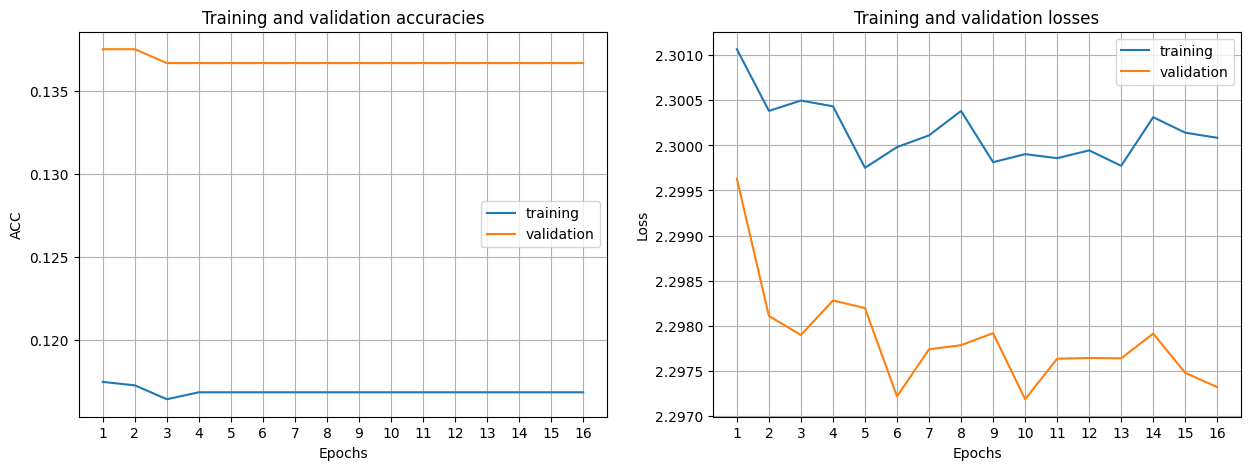

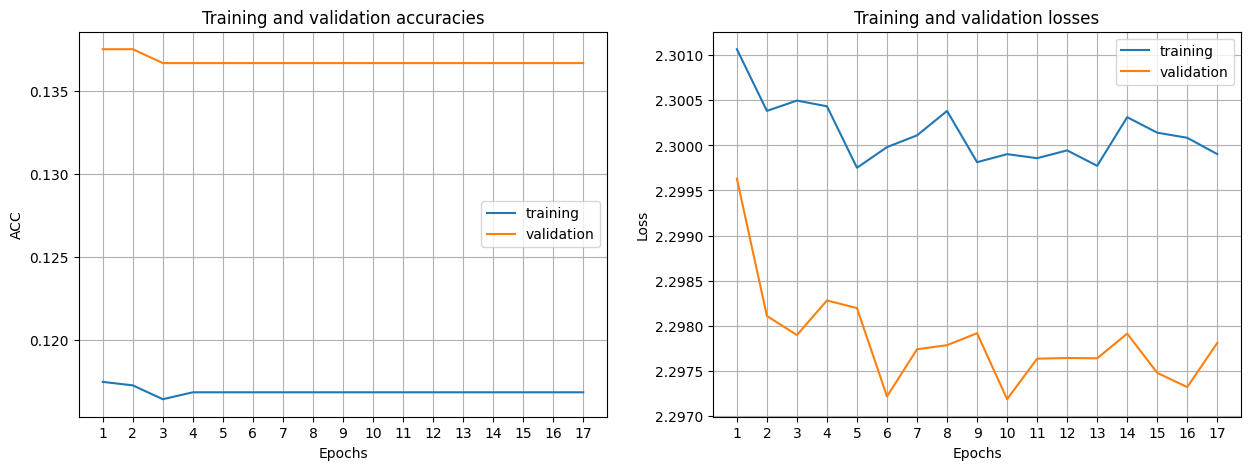

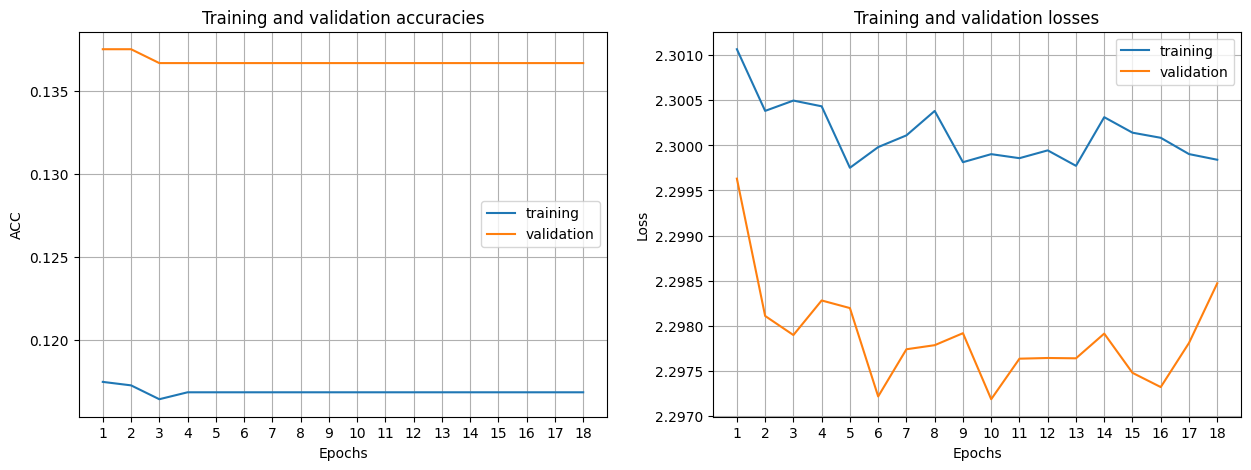

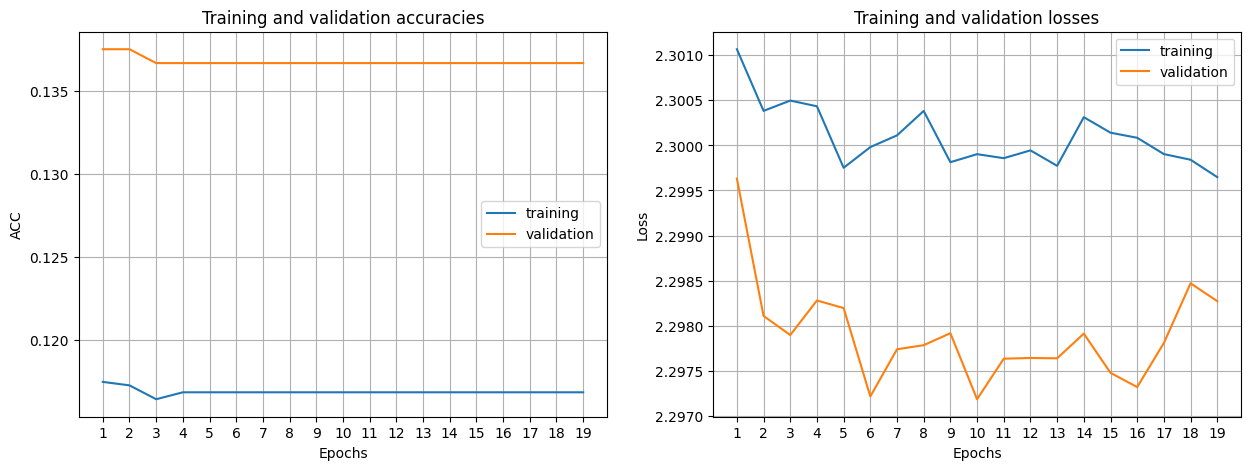

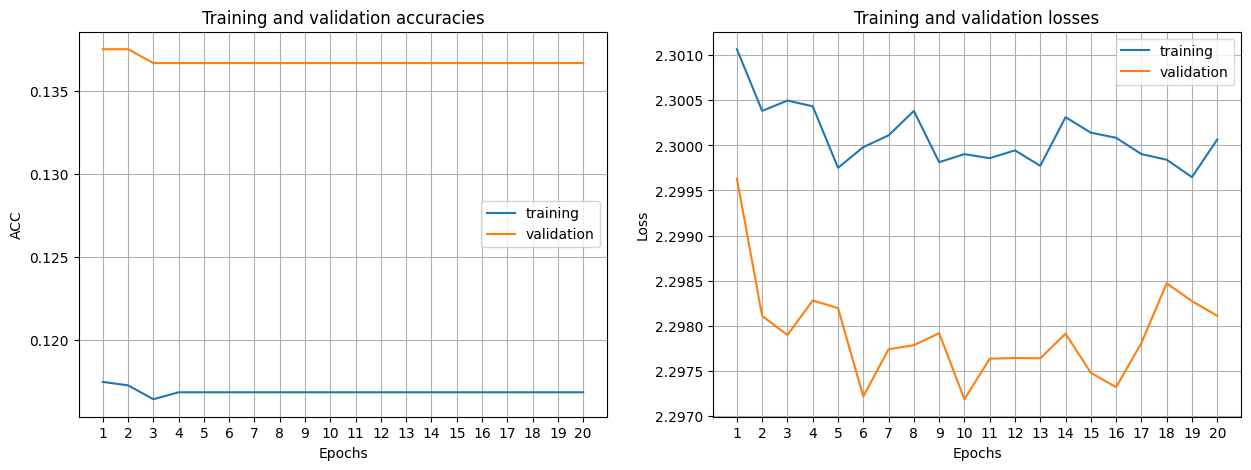

In [ ]:
experiment_quantum = fit(epochs=20, lr=lr, model_temp=model_quantum, train_loader=train_loader_2, val_loader=test_loader_2, bs=None, device=device, file_path=path_folder_quantum)